In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from nansat import Nansat, Domain, NSR

from sea_ice_drift.lib import get_spatial_mean, get_uint8_image
from sea_ice_drift.ftlib import feature_tracking
from sea_ice_drift.pmlib import pattern_matching



%matplotlib inline

In [3]:
# Download arrays
#!wget https://github.com/nansencenter/sea_ice_drift_test_files/raw/master/S1B_EW_GRDM_1SDH_20200123T120618.npy
#!wget https://github.com/nansencenter/sea_ice_drift_test_files/raw/master/S1B_EW_GRDM_1SDH_20200125T114955.npy


f1 = "/home/jovyan/work/icedrift/Cirfa_cruise/Drift_algorithm/Full_res/RS2/HH/RS2-SGF-SCNA-DES-03-May-2022_08.30-KNOS_47548646_Cal_EC.tif"

#"C:\Anna\Icedrift\Cirfa_cruise\Drift_algorithm\Full_res\RS2\HH\RS2-SGF-SCNA-DES-03-May-2022_08.30-KNOS_47548646_Cal_EC.tif"
f2 = "/home/jovyan/work/icedrift/Cirfa_cruise/Drift_algorithm/input data/subset_4_of_RS2_SCNB_20220501_074834_DES_282_HH.tif"

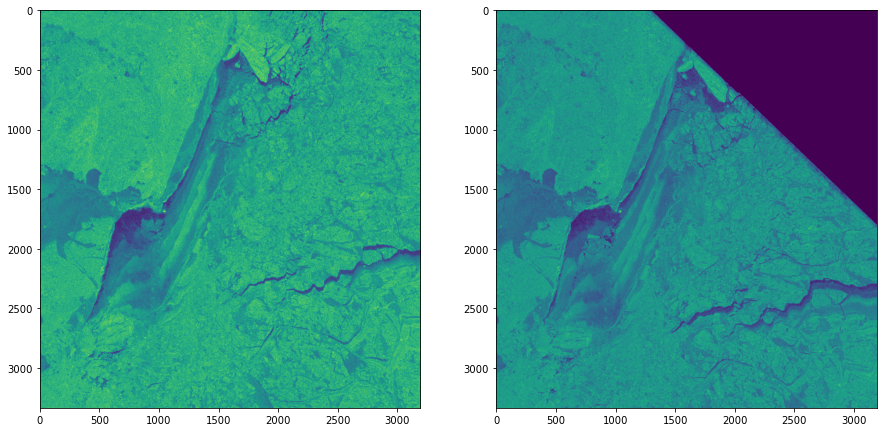

In [4]:
# load example arrays
#a1 = np.load(f1,allow_pickle=True)
#a2 = np.load(f2,allow_pickle=True)


a1 = plt.imread( "/home/jovyan/work/icedrift/Cirfa_cruise/Drift_algorithm/input data/subset_3_of_S1_EWM_20220430_0802_DES_053_HH.tif")
a2 = plt.imread("/home/jovyan/work/icedrift/Cirfa_cruise/Drift_algorithm/input data/subset_4_of_RS2_SCNB_20220501_074834_DES_282_HH.tif")


fig, ax = plt.subplots(1,2, figsize=(15,10))
im0 = ax[0].imshow(a1)
#plt.colorbar(im0, ax=ax[0])
im1 = ax[1].imshow(a2)
#plt.colorbar(im1, ax=ax[1])
plt.show()

In [5]:
type(a1)

numpy.ndarray

In [6]:
# normalize array values

def prepare_array(img):
    img = 10 * np.log10(img)
    img -= get_spatial_mean(img)
    img = get_uint8_image(img, None, None, 1, 99)
    return img

a1 = prepare_array(a1)
a2 = prepare_array(a2)

fig, ax = plt.subplots(1,2, figsize=(8,2))
im0 = ax[0].imshow(a1, clim=[0, 255])
plt.colorbar(im0, ax=ax[0])
im1 = ax[1].imshow(a2, clim=[0, 255])
plt.colorbar(im1, ax=ax[1])
plt.show()

/tmp/ipykernel_12843/3267676995.py:4: RuntimeWarning: divide by zero encountered in log10
  img = 10 * np.log10(img)


TypeError: array type float16 is unsupported in linalg

In [7]:
# Create two Nansat objects with fake georeference (Mercator projection).
# The same georefercne will be use for retrieval of drift.
# True knowledge about georeference of input arrays is prefered.

srs = NSR(3396)
rows, cols = a1.shape
pixel_size = 100 # meters
d = Domain(srs.wkt, f'-te 0 0 {cols*pixel_size} {rows*pixel_size} -ts {cols} {rows}')
n1 = Nansat.from_domain(d, a1)
n2 = Nansat.from_domain(d, a2)

In [8]:
# Run Feature Tracking
# get start/end coordinates in the image coordinate system (colums/rows)  
c1, r1, c2, r2 = feature_tracking(n1, n2, nFeatures=20000, ratio_test=0.6, max_drift=100000, verbose=True)

Key points found: 20000
Key points found: 20000
Domain filter: 20000 -> 20000
Domain filter: 20000 -> 20000
Keypoints matched 0.956599235534668
Ratio test 0.600000 found 216 keypoints
MaxDrift filter: 216 -> 216
LSTSQ filter: 216 -> 216


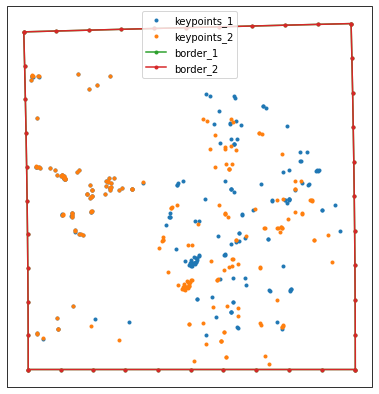

In [9]:
# Plot identified and matched keypoints in geographic coordinates

# convert row/column coordinates of matched features to lon/lat
lon1ft, lat1ft = n1.transform_points(c1, r1)
lon2ft, lat2ft = n2.transform_points(c2, r2)

# get lon/lat coordinates of the border of images
lon1b, lat1b = n1.get_border()
lon2b, lat2b = n2.get_border()


# get hi-res landmask
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])

plt.figure(figsize=(7,7))
ax = plt.axes(projection=ccrs.Mercator())
ax.add_feature(land_50m, zorder=0, edgecolor='black')
ax.plot(lon1ft, lat1ft, '.', label='keypoints_1', transform=ccrs.PlateCarree())
ax.plot(lon2ft, lat2ft, '.', label='keypoints_2', transform=ccrs.PlateCarree())
ax.plot(lon1b, lat1b, '.-', label='border_1', transform=ccrs.PlateCarree())
ax.plot(lon2b, lat2b, '.-', label='border_2', transform=ccrs.PlateCarree())
ax.legend()
plt.show()

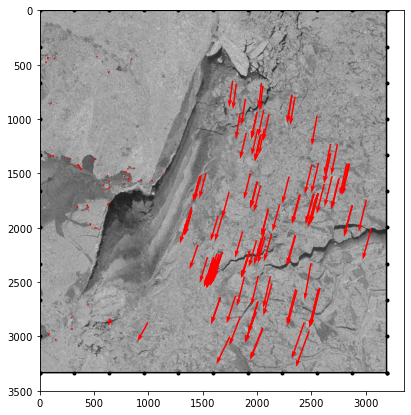

In [11]:
# Plot ice drift on top of image_1

# end points in image_1 coordinate system
n1c2, n1r2 = n1.transform_points(lon2ft, lat2ft, DstToSrc=1)

# ice drift components in image_1 coordinate system
dr = n1r2 - r1
dc = n1c2 - c1

# border of image_2 in image_1 coordinate system
n1lon2b, n1lat2b = n1.transform_points(lon2b, lat2b, DstToSrc=1)

# plot of ice drift. Arrows are 5 times longer than actual drift
plt.figure(figsize=(7,7))
plt.imshow(n1[1], cmap='gray')
plt.quiver(c1, r1, dc, dr, color='r', angles='xy', scale_units='xy', scale=1)
plt.plot(n1lon2b, n1lat2b, 'k.-')
plt.show()

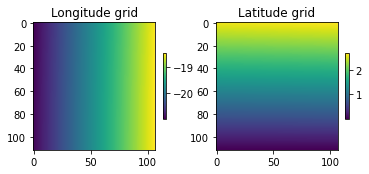

In [12]:
# Create lon/lat grids 

# lon/lat grids in polar stereographic projection covering image_1
pm_step = 30 # lon/lat grids are subsampled
lon1pm, lat1pm = d.get_geolocation_grids(pm_step)
plt.subplot(1,2,1);plt.imshow(lon1pm);plt.colorbar(shrink=0.3);plt.title('Longitude grid')
plt.subplot(1,2,2);plt.imshow(lat1pm);plt.colorbar(shrink=0.3);plt.title('Latitude grid')
plt.show()

In [37]:
# Run Pattern Matching for each element in lon1pm/lat1pm matrix
# ice displacement upm and vpm are returned in meters in Mercator (faked) projection
upm, vpm, apm, rpm, hpm, lon2pm, lat2pm = pattern_matching(lon1pm, lat1pm, n1, c1, r1, n2, c2, r2,
                                                          srs=srs.ExportToProj4())

/opt/conda/lib/python3.10/site-packages/sea_ice_drift-0.7.1-py3.10.egg/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in true_divide


00% 00990.0 00030.0 00990.0 00028.0 +00.0 0.27 4.22

/opt/conda/lib/python3.10/site-packages/sea_ice_drift-0.7.1-py3.10.egg/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in true_divide


/opt/conda/lib/python3.10/site-packages/sea_ice_drift-0.7.1-py3.10.egg/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.10/site-packages/sea_ice_drift-0.7.1-py3.10.egg/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.10/site-packages/sea_ice_drift-0.7.1-py3.10.egg/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in true_divide


85% 02430.0 02580.0 02341.0 02912.0 -03.0 0.30 3.81676% 00150.0 02340.0 00149.0 02339.0 -03.0 0.32 6.3897% 02280.0 02940.0 02160.0 03255.0 -03.0 0.55 6.9094% 01620.0 02850.0 01517.0 03090.0 -03.0 0.50 6.3789% 02070.0 02700.0 01979.0 02991.0 -03.0 0.67 5.46
 Pattern matching - OK! ( 10 sec)


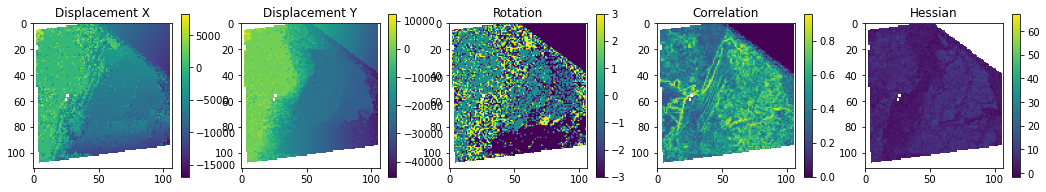

In [38]:
# plot retrieved matrices
titles = ['Displacement X', 'Displacement Y', 'Rotation', 'Correlation', 'Hessian']
fig, ax = plt.subplots(1,5, figsize=(18,3))
for i, a in enumerate([upm, vpm, apm, rpm, hpm]):
    ax[i].set_title(titles[i])
    im = ax[i].imshow(a)
    plt.colorbar(im, ax=ax[i])

plt.show()

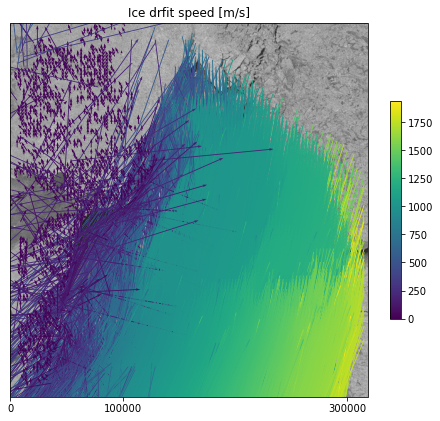

In [50]:
# compute ice drift speed [m/s]
delta_t = 24
u = upm / delta_t
v = vpm / delta_t
speed = np.sqrt(v**2+u**2) 

# plot valid vectors in Polar stereographic projection
gpi = (rpm > 0.4) 
# X/Y grids in polar stereographic projection covering image_1
x1pm, y1pm = d.get_geolocation_grids(pm_step, dst_srs=srs)

# spacial reference for plotting
crs = ccrs.Mercator()

plt.figure(figsize=(8,8))
ax = plt.axes(projection=crs)

'''
ax.imshow(a1, cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper')
quiv=ax.quiver(x1pm[gpi], y1pm[gpi], upm[gpi], vpm[gpi], rpm[gpi], scale=100000, cmap='jet', width=0.008)
plt.colorbar(quiv, shrink=0.5)
plt.quiverkey(quiv, 110000, -770000, 0.05, '0.05 m/s', coordinates='data')
plt.title('Ice drfit speed [m/s]')
ax.add_feature(land_50m, edgecolor='black')
ax.set_xticks([-300000, -100000, 0, 100000, 300000])
ax.set_yticks([-700000, -500000, -300000])

'''

ax.imshow(a1, cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper')
quiv=ax.quiver(x1pm[gpi], y1pm[gpi], u[gpi], v[gpi],speed[gpi], scale=500)
plt.colorbar(quiv, shrink=0.5)
plt.quiverkey(quiv, 110000, -770000, 0.05, '0.05 m/s', coordinates='data')
plt.title('Ice drfit speed [m/s]')
ax.add_feature(land_50m, edgecolor='black')
ax.set_xticks([-300000, -100000, 0, 100000, 300000])
ax.set_yticks([-700000, -500000, -300000])


ax.set_xlim([x1pm.min(), x1pm.max()])
ax.set_ylim([y1pm.min(), y1pm.max()])
plt.show()

In [ ]:
## Generate test files for drift_from_arrays.py
"""
# use original Sentinel-1 SAR files (download from colhub.met.no)
f1 = 'S1B_EW_GRDM_1SDH_20200123T120618_20200123T120718_019944_025BA1_D4A2.SAFE'
f2 = 'S1B_EW_GRDM_1SDH_20200125T114955_20200125T115055_019973_025C81_EC1A.SAFE'

n1 = Nansat(f1)
n2 = Nansat(f2)

# projection (https://epsg.io/3413)
srs = NSR(3413)

# projected coordinates of the first image corners
rows, cols = n1.shape()
n1x, n1y = n1.transform_points([0,cols,cols,0], [0,0,rows,rows], dst_srs=srs)

# domain of interest with resolution 500 m
d = Domain(srs.wkt, '-te %f %f %f %f -tr 100 100' % (
    n1x.mean()-100000,
    n1y.mean()-100000,
    n1x.mean()+100000,
    n1y.mean()+100000))

n1.resize(0.5)
s0hh = n1['sigma0_HH']
n1b = Nansat.from_domain(n1, s0hh)
n1b.reproject_gcps()
n1b.vrt.tps = True
n1b.reproject(d)
s0hh1_pro = n1b[1]

n2.resize(0.5)
s0hh = n2['sigma0_HH']
n2b = Nansat.from_domain(n2, s0hh)
n2b.reproject_gcps()
n2b.vrt.tps = True
n2b.reproject(d)
s0hh2_pro = n2b[1]

np.save('S1B_EW_GRDM_1SDH_20200123T120618', s0hh1_pro)
np.save('S1B_EW_GRDM_1SDH_20200125T114955', s0hh2_pro)
#"""

In [28]:
# shortest version
def prepare_array(img):
    img = 10 * np.log10(img)
    img -= get_spatial_mean(img)
    img = get_uint8_image(img, None, None, 1, 99)
    return img

srs = NSR(3396) # fake projection
pixel_size = 100 # meters for fake grid
pm_step = 30 # subsampling for lon/lat grids

a1 = np.load('S1B_EW_GRDM_1SDH_20200123T120618.npy')
a2 = np.load('S1B_EW_GRDM_1SDH_20200125T114955.npy')
a1 = prepare_array(a1)
a2 = prepare_array(a2)

rows, cols = a1.shape
d = Domain(srs.wkt, f'-te 0 0 {cols*pixel_size} {rows*pixel_size} -ts {cols} {rows}')
n1 = Nansat.from_domain(d, a1)
n2 = Nansat.from_domain(d, a2)
c1, r1, c2, r2 = feature_tracking(n1, n2, nFeatures=20000, ratio_test=0.6, max_drift=10000, verbose=True)

lon1pm, lat1pm = d.get_geolocation_grids(pm_step)
upm, vpm, apm, rpm, hpm, lon2pm, lat2pm = pattern_matching(lon1pm, lat1pm, n1, c1, r1, n2, c2, r2, srs=srs.ExportToProj4())

VMIN:  -6.971361312866211
VMAX:  4.550561308860771
VMIN:  -7.0100141572952275
VMAX:  4.6698570871353136
Key points found: 20000
Key points found: 20000
Domain filter: 20000 -> 20000
Domain filter: 20000 -> 20000
Keypoints matched 1.2765438556671143
Ratio test 0.600000 found 3566 keypoints
MaxDrift filter: 3566 -> 3566
LSTSQ filter: 3566 -> 3566
100% 01530.0 01950.0 01529.0 01949.0 +00.0 0.67 14.62
 Pattern matching - OK! (  4 sec)
